In [1]:
# 파이토치 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


# 데이터셋 불러오기
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10, STL10

# 데이터 로더
from torch.utils.data.dataloader import DataLoader, Dataset

# 최적화 알고리즘
from torch.optim import optimizer
from torch.autograd import Variable

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import skimage

import random

import pandas as pd
import sklearn

In [2]:
# 시드 고정
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    return f'현재 사용중인 seed는 [{torch.initial_seed()}]'

fix_seed(1)

'현재 사용중인 seed는 [1]'

# 데이터 호출 

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# # 데이터 호출(STL10)
# path = '/data/gongmo/team4/chan/STL10'


# train_data = STL10(
#     root = path,
#     split='train',
#     download=True,
#     transform=transform
# )

# test_data = STL10(
#     root = path,
#     split='test',
#     download=True,
#     transform=transform
# )

In [5]:
# 데이터 호출(CIFAR 10)
path = '/data/gongmo/team4/chan/CIFAR10'

train_data = CIFAR10(
    root = path,
    train=True,
    download=True,
    transform=transform
)

test_data = CIFAR10(
    root = path,
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(1)

batch_size = 32
num_workers = 4

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
)

In [8]:
print(train_dataloader.dataset)
print(f'Total {len(train_dataloader)} images in 1 batch')

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data/gongmo/team4/chan/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Total 1563 images in 1 batch


# 모델 불러오기 및 CAM 학습용으로 pretrained 모델 재정의

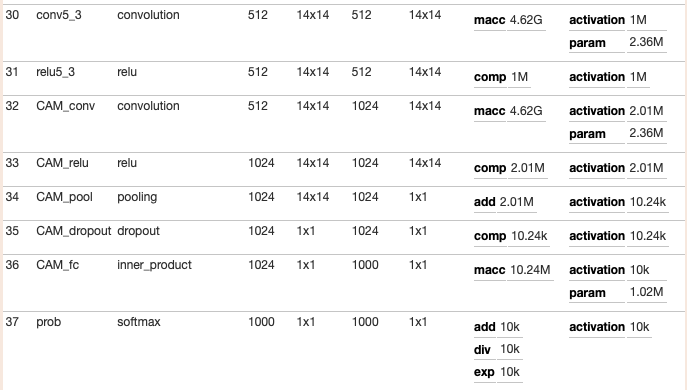

관련 주소 : https://github.com/zhoubolei/CAM/blob/master/models/deploy_vgg16CAM.prototxt 참고하여 구현

In [9]:
import copy

# pretrained 모델 불러오기
vgg16 = models.vgg16(weights=True)

class vgg16_cam(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = copy.deepcopy(vgg16) # 가중치 복사
        
        # Maxpool 제거하기(14*14*512 size 유지 목적)
        self.conv = self.model.features[:-1]

        # CAM 추가
        self.CAM_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Average Pooling
        self.CAM_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Dropout(0.5) 
        )

        # after Flatten
        self.CAM_fc = nn.Linear(in_features=1024, out_features=10)

    # 순전파
    def forward(self, x):
        x = self.conv(x)

        # 나머지 모델들 쌓아나가서 분류
        x = self.CAM_conv(x)
        features = x
        x = self.CAM_pool(x)

        x = torch.flatten(x, 1)

        x = self.CAM_fc(x)

        return x, features 

/data/gongmo/team4/miniconda3/envs/chan/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary
model = vgg16_cam()
summary(model, input_size=(3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
            Conv2d-6         [-1, 64, 224, 224]          36,928
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
           Conv2d-12        [-1, 128, 112, 112]          73,856
             ReLU-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

# 학습

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [13]:
# multi-GPU 학습
model = nn.DataParallel(model, device_ids = [0, 1, 2, 3])
model.to(device)

# 학습 조건 설정
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001, momentum=0.9, weight_decay=5e-4) 

In [16]:
# VGG 학습
model.train()

num_epochs = 2 # 에폭 설정

loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        output = model(images) # 모델 예측 시행

        # 예측 정확도 계산
        n_correct = (output.argmax(axis=1)==labels).sum().item()
        
        # 예측에 따른 손실 계산 및 출력
        loss = criterion(output, labels)
        
        # backward pass 
        optimizer.zero_grad() # 가중치 변화를 0으로 만들고
        loss.backward() # 역전파를 수행하고
        optimizer.step() # 가중치를 갱신

        running_loss += loss.item()
        loss_arr.append(loss.item())
        # 100번에 한번씩 loss 출력
        if i % 99 == 98: 
            print(f'Training epoch : {epoch+1}, [{i * len(images)} / {len(train_dataloader.dataset)}] ({100 * i / len(train_dataloader):0.0f}%), Loss : {running_loss/99:0.6f}, accuracy : {(n_correct/labels.size(0))*100:.2f}' )
            running_loss = 0.0
        
print('학습종료!')

Training epoch : 1, [12544 / 50000] (25%), Loss : 0.263189, accuracy : 89.06
Training epoch : 1, [25216 / 50000] (50%), Loss : 0.241190, accuracy : 93.75
Training epoch : 1, [37888 / 50000] (76%), Loss : 0.246461, accuracy : 96.09
Training epoch : 2, [12544 / 50000] (25%), Loss : 0.221198, accuracy : 94.53
Training epoch : 2, [25216 / 50000] (50%), Loss : 0.224598, accuracy : 90.62
Training epoch : 2, [37888 / 50000] (76%), Loss : 0.206332, accuracy : 89.84
학습종료!


In [13]:
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(data)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 91 %
Accuracy of automobile : 83 %
Accuracy of  bird : 93 %
Accuracy of   cat : 71 %
Accuracy of  deer : 93 %
Accuracy of   dog : 78 %
Accuracy of  frog : 87 %
Accuracy of horse : 80 %
Accuracy of  ship : 94 %
Accuracy of truck : 100 %


In [19]:
# 모델 저장
PATH = '/data/gongmo/team4/chan/trained_weight/vgg16_CAM_cifar.pt'
# torch.save(model.module.state_dict(), PATH)

# 학습된 모델로 CAM 돌리기

In [10]:
PATH = '/data/gongmo/team4/chan/trained_weight/vgg16_CAM_cifar.pt'
model = vgg16_cam()

In [11]:
device = torch.device("cuda")
model.load_state_dict(torch.load(PATH))
model.to(device)

vgg16_cam(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

# CAM 결과 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : cat, REAL : cat, INDEX : 0 *********


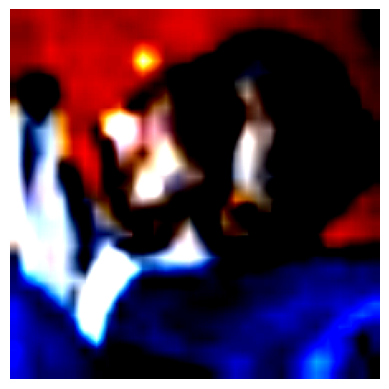

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


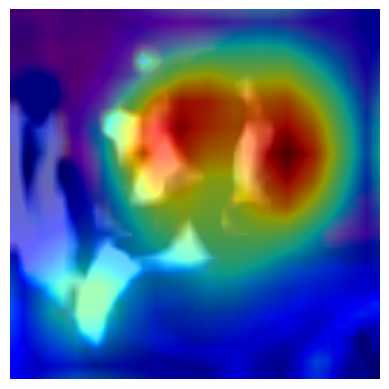

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : ship, REAL : ship, INDEX : 1 *********


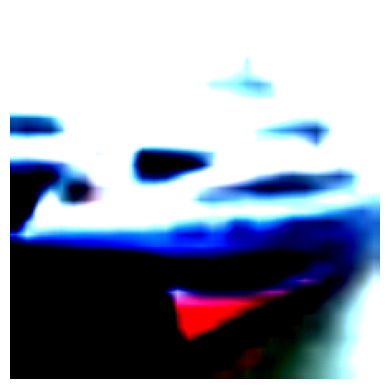

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


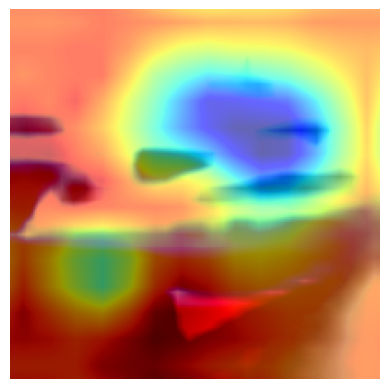

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : ship, REAL : ship, INDEX : 2 *********


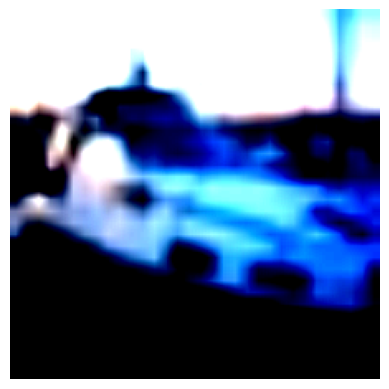

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


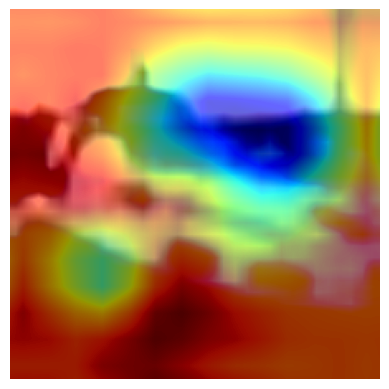

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : airplane, REAL : airplane, INDEX : 3 *********


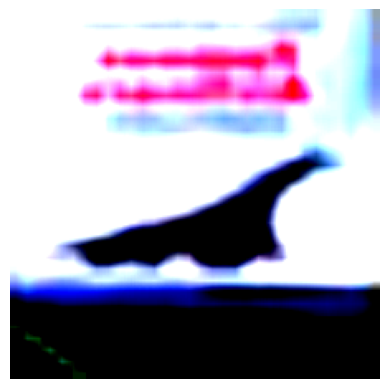

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


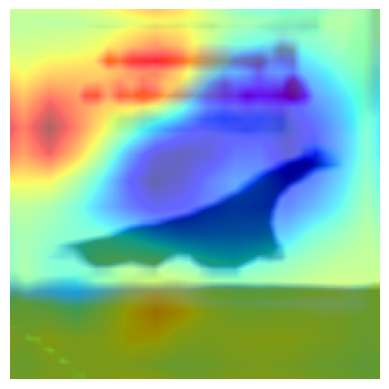

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : frog, REAL : frog, INDEX : 4 *********


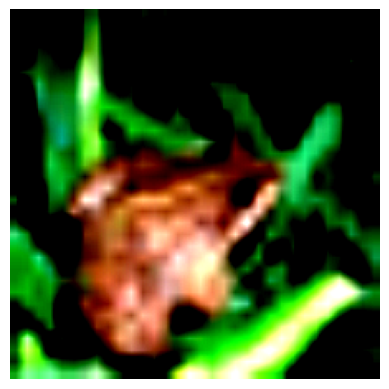

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


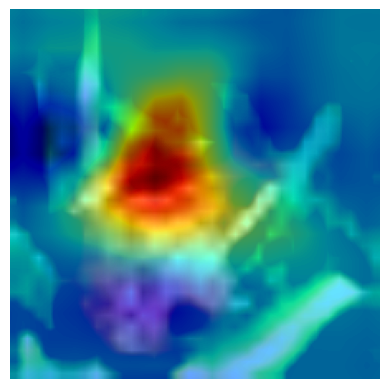

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


********* ANSWER : frog, REAL : frog, INDEX : 5 *********


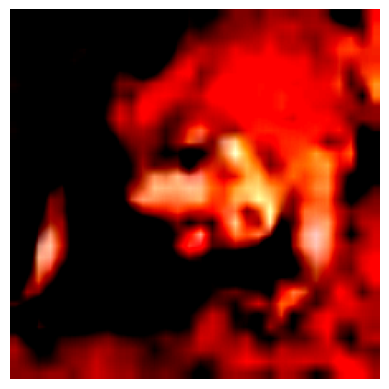

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


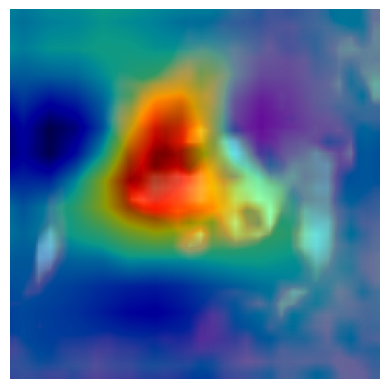

In [21]:
model.eval() # eval 모드 설정

params = list(model.parameters()) # 예측을 통해 얻어진 parameter 수집

for data in test_dataloader:    
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs, feature = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        print(f"********* ANSWER : {classes[int(predicted[i])]}, REAL : {classes[int(labels[i])]}, INDEX : {i} *********")

        # 모델이 예측한 인덱스(predicted)의 parameter 값과 feature map을 결합
        # matmul 사용을 위해 (14,14) shape을 196 으로 만들었다가 다시 (14, 14)로 설정
        # 이후 cpu에서 값을 보기 위해 detach하고 데이터 조작을 위해 numpy 변환 및 copy
        mask = params[-2][predicted[i]].matmul(feature[0].reshape(1024,196)).reshape(14,14).detach().cpu().numpy().copy()

        image = images[i].permute(1,2,0).detach().cpu().numpy()

        # 최종 출력시킬 이미지 해상도 설정(가로, 세로)
        size = 224

        # 동일 size로 맞춰주기
        mask = skimage.transform.resize(mask, (size,size))
        image = skimage.transform.resize(image, (size,size))

        # 원본 이미지 출력
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        # CAM 결과와 함께 출력
        plt.imshow(mask, cmap='jet')
        plt.imshow(image, alpha=0.4)
        plt.axis('off')
        plt.show()
        if i == 5:
            break
    break